This notebook takes you throughs some features and data generation using the copulas class

In [1]:
import warnings
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import sys
sys.path.insert(1, '../')
from generate_timeseries import *

First, we'll simply draw some samples from copula distribution with defined marginals.

In [2]:
n = 4  # number of time-series to generate
t = 1000  # length of time series (arbitrary units)

# generate copula sublcass paramter and markovian time series property
cop = Clayton(alpha=10, markovian=True)

# now define the marginal distribution that you want the time series to have
cop.define_marginal(marginal_family="gamma", loc=None, scale=None)

# generate the samples
samples = cop.sample(n, t)

Now plot those samples for visualization.

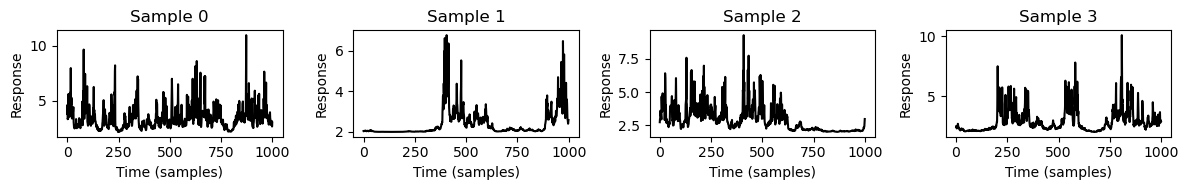

In [3]:
nc = np.min((n, 5))
nr = int(np.ceil(n / nc))
plt.figure(figsize=(nc*3, 2*nr))
for nn in range(n):
    plt.subplot(nr, nc, nn+1)
    plt.plot(samples[nn], c="black")
    plt.title("Sample " + str(nn))
    plt.xlabel("Time (samples)")
    plt.ylabel("Response")
plt.tight_layout()

Now, let's explore other aspects of the copula object, including the joint copula density and generating random and nonrandom variables from the density.

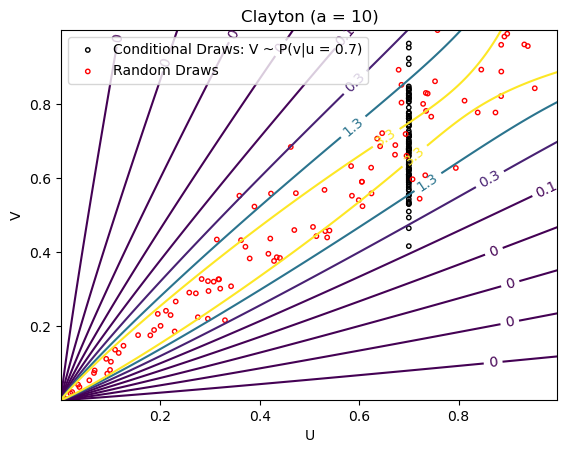

In [4]:
# first, get the density using default arguments
u, v, p = cop.density()

# to visualize the density, we linspace the quantiles to draw important ones
qs = np.quantile(p, np.linspace(0, 1, 10))

# Now plot the density with some nice formatting
fig, ax = plt.subplots()
CS = ax.contour(u, v, p, levels=qs, cmap="viridis", vmax=qs[-2], vmin=qs[0])
ax.set_xlabel("U")
ax.set_ylabel("V")
ax.set_title(cop.copula_family + " (a = " + str(cop.alpha) + ")")


def fmt(x):
    """
    Formatter for the contour labels
    """
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s}"


ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)


# Plot some random realizations of the copula given given u = 0.7
n_draws = 100  # number draws to make
given_u = np.repeat(0.7, n_draws)  # specify which u in [0,1]

# generate from the other variable given u
v_draws = np.array([cop.variable(uu) for uu in given_u])

# plot those values in black
plt.scatter(given_u, v_draws, facecolors='none', edgecolors='k', s=10,
            label="Conditional Draws: V ~ P(v|u = " + str(given_u[0]) + ")")

# Alternatively, we randomly draw by providing random numbers to "variable"
u_random = stats.uniform.rvs(0, 1, n_draws)
w_random = stats.uniform.rvs(0, 1, n_draws)
v_random = cop.variable(u_random, w_random)
plt.scatter(u_random, v_random, facecolors='none',
            edgecolors='r', s=10, label="Random Draws")
plt.legend()

Let's verify some fundamental properties of the markovian copula with the defined marginal.
The time series generated by the copula itself (u(t)) should have a uniform distribution.
The time series after passing through the defined marginal distribution should follow the distribution defined.
The joint distribution of u(t) and u(t+1) should follow the joint copula distribution.
The joint distribution of x(t) and x(t+1) will follow an unspecified, probably complicated distribution that is difficult to characterize.


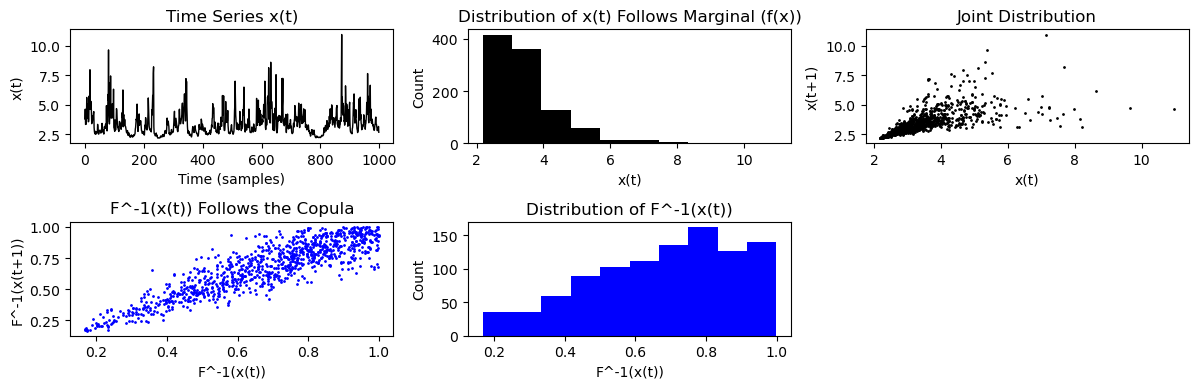

In [5]:
# Here, we sample from the copula, but apply no marginal distribution to the
# samples. i.e. we could set the marginal_family to "uniform", or just pull the
# uniform_samples object from the copula. This is u(t).
nn = 0  # select the index of the sample you want to explore
# here, we pull the samples before they were passed to the marginal distribution
uniform_samples = cop.uniform_samples
u_t = uniform_samples[nn][0:t-1]  # the first variable from the copula u(t)
u_tp1 = uniform_samples[nn][1:]  # the second variable u(t+1)

# x(t) has the marginal distribution applied to it:
x_t = samples[nn][0:t-1]  # considered the "time-series" x(t)
x_tp1 = samples[nn][1:]  # x(t+1)

nr = 2
nc = 3
plt.figure(figsize=(12, 4))

plt.subplot(nr, nc, 1)
plt.title("Time Series x(t)")
plt.plot(x_t, color="k", linewidth=1)
plt.ylabel("x(t)")
plt.xlabel("Time (samples)")

plt.subplot(nr, nc, 2)
plt.hist(x_t, color="k")
plt.ylabel("Count")
plt.xlabel("x(t)")
plt.title("Distribution of x(t) Follows Marginal (f(x))")
plt.tight_layout()


plt.subplot(nr, nc, 3)
plt.scatter(x_t, x_tp1, s=1, color="k")
plt.xlabel("x(t)")
plt.ylabel("x(t+1)")
plt.title("Joint Distribution")
plt.tight_layout()


plt.subplot(nr, nc, 4)
# " + copula + " samples | α = " + str(a))
plt.title("F^-1(x(t)) Follows the Copula")
plt.scatter(u_t, u_tp1, s=1, color='blue')
plt.xlabel("F^-1(x(t))")
plt.ylabel("F^-1(x(t+1))")

plt.subplot(nr, nc, 5)
plt.title("Distribution of F^-1(x(t))")
plt.hist(u_t, color="blue")
plt.xlabel("F^-1(x(t))")
plt.ylabel("Count")

plt.tight_layout()